## How to use this script
1. Export your ChatGPT conversations. From your ChatGPT account, go to Settings -> Data controls -> Export
2. Unzip the data export
3. Point `convo_folder` to your exported data folder
4. Change `local_tz` to your local timezone so that it gets the correct timestamp of each conversation.

In [2]:
import os
folder_path = os.getenv('CONVO_FOLDER_PATH')

In [3]:
convo_folder = folder_path # change to where your exported ChatGPT folder is 
local_tz = 'US/Eastern' # change to your local timezone.
# pytz.all_timezones # uncomment to see a list of all supported timezones.

In [4]:
import json

with open(f'{convo_folder}/conversations.json', 'r') as f:
    convs = json.load(f)

In [5]:
import pytz

from datetime import datetime, timezone, timedelta

convo_times = []
for conv in convs:
    # Given Unix timestamp
    unix_timestamp = conv['create_time']

    # Convert to UTC datetime
    utc_datetime = datetime.fromtimestamp(unix_timestamp, tz=timezone.utc)

    # Convert UTC datetime to local timezone
    pt_datetime = utc_datetime.astimezone(pytz.timezone(local_tz))
    convo_times.append(pt_datetime)

In [11]:
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter

def create_year_heatmap(convo_times, year):
    # Convert convo_times to dates and filter for the given year
    just_dates = [convo.date() for convo in convo_times if convo.year == year]

    date_counts = Counter(just_dates)

    # Create a full year date range for the calendar
    start_date = datetime(year, 1, 1).date()
    end_date = datetime(year, 12, 31).date()

    total_days = (end_date - start_date).days + 1
    date_range = [start_date + timedelta(days=i) for i in range(total_days)]

    # Prepare data for plotting
    data = []
    for date in date_range:
        week = ((date - start_date).days + start_date.weekday()) // 7
        day_of_week = date.weekday()
        count = date_counts.get(date, 0)
        data.append((week, day_of_week, count))

    weeks_in_year = (end_date - start_date).days // 7 + 1

    # Plot the heatmap
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')

    max_count_date = max(date_counts, key=date_counts.get)
    max_count = date_counts[max_count_date]
    p90_count = np.percentile(list(date_counts.values()), 90)
    for week, day_of_week, count in data:
        color = plt.cm.Greens((count + 1) / p90_count) if count > 0 else 'lightgray'
        rect = patches.Rectangle((week, day_of_week), 1, 1, linewidth=0.5, edgecolor='black', facecolor=color)
        ax.add_patch(rect)

    # Replace week numbers with month names below the heatmap
    month_starts = [start_date + timedelta(days=i) for i in range(total_days)
                    if (start_date + timedelta(days=i)).day == 1]
    for month_start in month_starts:
        week = (month_start - start_date).days // 7
        plt.text(week + 0.5, 7.75, month_start.strftime('%b'), ha='center', va='center', fontsize=10, rotation=0)

    # Adjustments for readability
    ax.set_xlim(-0.5, weeks_in_year + 0.5)
    ax.set_ylim(-0.5, 8.5)
    plt.title(
        f'{year} ChatGPT Conversation Heatmap (total={sum(date_counts.values())}).\nMost active day: {max_count_date} with {max_count} convos.',
        fontsize=16
    )
    plt.xticks([])
    plt.yticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.gca().invert_yaxis()
    plt.show()

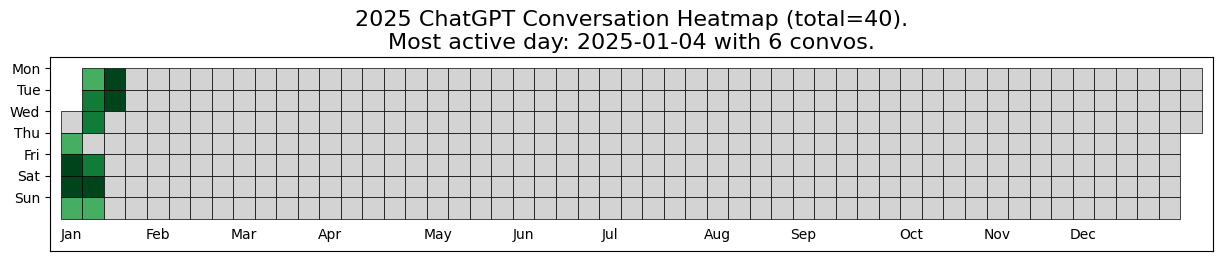

In [12]:
create_year_heatmap(convo_times, 2025)

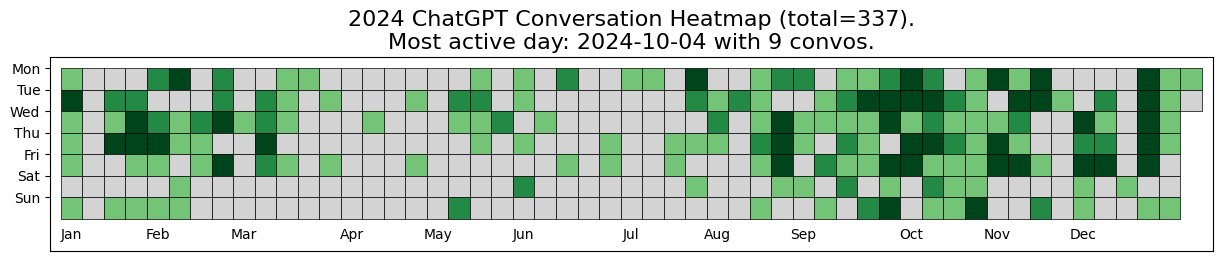

In [13]:
create_year_heatmap(convo_times, 2024)